## 引言
#### 研究目的：

本文参考方正证券'聆听高频世界的声音'系列研报的第7篇《枯树生花，基于日内模式的动量因子革新》内容，对动量因子进行创新性的探索。在量化投资的领域， 动量是最常见的选股因子之一。 不同于国外市场“短期反转、中期动量” 的特点， A股市场呈现较为显著的中长期反转效应。

然而，令人失望的是，动量因子的反转收益在中国股票市场中也并非一直稳定。换言之， 传统动量因子不是好的 Alpha 因子。

动量因子的困境并非毫无出路。方正金工团队基于“市场行为特征，在日内不同时段存在差异”的基本事实， 考察了动量因子的日内精细结构， 重新构造出了最优化的动量因子。在下面的研究中，并没有发现有强劲的选股能力，但是，构造的新动量因子的选股能力（IR=0.84），显著地优于传统动量因子（IR=0.12），有一定的超额收益。


#### 动量因子重新构造：

不同的交易者群体，会有不同的行为模式，这是几乎不证自明的命题。对于交易日内的不同时段，交易者成分的系统性差异，会导向不同的市场行为特征，从而形成各式各样的日内模式（intraday patterns）。按照这个思路，
我们将每日股票的涨跌切割为 5 个时段，再重新加权组装得到最优动量因子。


#### 研究思路：

（1）设置股票池及时间段，统计切割后的5段收益，进行因子值记录。

（2）计算统计期内的因子值指标数据IC、ICIR值、标准差。

（3）进行最优化权重求解。

（4）收益回测分析，统计分组，多空组合、多头收益净值曲线。

#### 研究结论：

（1）最优动量因子在全市场的五分组多空对冲， 未能取得较为稳定的超额收益。

（2）多头部分收益，有一定的超额收益，超额收益年化收益为 8.4%，最大回撤为 8.58%。

（3）特别地，在对因子数据进行中性化处理后，超额年化有少许提升，为9.29%，最大回撤为8.3%


In [1]:
# 风险及免责提示：该策略由聚宽用户在聚宽社区分享，仅供学习交流使用。
# 原文一般包含策略说明，如有疑问请到原文和作者交流讨论。
# 原文网址：https://www.joinquant.com/view/community/detail/56ea4cd9e4a50f76e4357412e3836f8c?type=1
# 标题：枯树生花，基于日内模式的动量因子革新

#开始时运行该模块，导入库，工具函数
#工具包、工具函数
import time
from datetime import datetime, timedelta
from jqdata import *
from jqfactor import *
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import datetime
import warnings  
warnings.filterwarnings('ignore') 
plt.style.use('ggplot')

#获取日期列表
def get_tradeday_list(start,end,frequency=None,count=None):
    if count != None:
        df = get_price('000001.XSHG',end_date=end,count=count)
    else:
        df = get_price('000001.XSHG',start_date=start,end_date=end)
    if frequency == None or frequency =='day':
        return df.index
    else:
        df['year-month'] = [str(i)[0:7] for i in df.index]
        if frequency == 'month':
            return df.drop_duplicates('year-month').index
        elif frequency == 'quarter':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='04') | (df['month']=='07') | (df['month']=='10') ]
            return df.drop_duplicates('year-month').index
        elif frequency =='halfyear':
            df['month'] = [str(i)[5:7] for i in df.index]
            df = df[(df['month']=='01') | (df['month']=='06')]
            return df.drop_duplicates('year-month').index 
        
def ret_se(start_date='2018-6-1',end_date='2018-7-1',stock_pool=None,weight=0):
    pool = stock_pool
    if len(pool) != 0:
        #得到股票的历史价格数据
        df = get_price(list(pool),start_date=start_date,end_date=end_date,fields=['close']).close
        df = df.dropna(axis=1)
        #获取列表中的股票流通市值对数值
        df_mkt = get_fundamentals(query(valuation.code,valuation.circulating_market_cap).filter(valuation.code.in_(df.columns)))
        df_mkt.index = df_mkt['code'].values
        fact_se =pd.Series(df_mkt['circulating_market_cap'].values,index = df_mkt['code'].values)
        fact_se = np.log(fact_se)
    else:
        df = get_price('000001.XSHG',start_date=start_date,end_date=end_date,fields=['close'])
        df['v'] = [1]*len(df)
        del df['close']
    #相当于昨天的百分比变化
    pct = df.pct_change()+1
    pct.iloc[0,:] = 1
    if weight == 0:
        #等权重平均收益结果
        se = pct.cumsum(axis=1).iloc[:,-1]/pct.shape[1]
        return se
    else:
        #按权重的方式计算
        se = (pct*fact_se).cumsum(axis=1).iloc[:,-1]/sum(fact_se)
        return se
    
#获取所有分组pct
def get_all_pct(pool_dict,trade_list,groups=5):
    num = 1
    for s,e in zip(trade_list[:-1],trade_list[1:]):
        stock_list = pool_dict[s]
        stock_num = len(stock_list)//groups
        if num == 0:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df1 = pd.concat(pct_se_list,axis=1)
            pct_df = pd.concat([pct_df,pct_df1],axis=0)
        else:
            pct_se_list = []
            for i in range(groups):
                pct_se_list.append(ret_se(start_date=s,end_date=e,stock_pool=stock_list[i*stock_num:(i+1)*stock_num]))
            pct_df = pd.concat(pct_se_list,axis=1)    
            num = 0
    return pct_df

def tradedays_before(date,count):#获取指定交易日往前推count天交易日
    date = get_price('000001.XSHG',end_date=date,count=count+1).index[0]
    return date

def ShiftTradingDay(date,shift):
    # 获取所有的交易日，返回一个包含所有交易日的 list,元素值为 datetime.date 类型.
    tradingday = get_all_trade_days()
    # 得到date之后shift天那一天在列表中的行标号 返回一个数
    date = datetime.date(int(str(date)[:4]),int(str(date)[5:7]),int(str(date)[8:10]))
    shiftday_index = list(tradingday).index(date)+shift
    # 根据行号返回该日日期 为datetime.date类型
    return tradingday[shiftday_index] 

#风险指标计算
def get_risk_index(return_se): #输入收益净值，从零算起
    
    total_returns = return_se[-1]
    total_an_returns = ((1+total_returns)**(250/len(return_se))-1)
    sharpe = (total_an_returns-0.04)/np.std(return_se)

    ret = return_se.dropna()
    ret = ret+1
    maxdown_list = []
    for i in range(1,len(ret)):
        low  = min(ret[i:])
        high = max(ret[0:i]) 
        if high>low:
            #print(high,low)
            maxdown_list.append((high-low)/high)
            #print((high-low)/high)
        else:
            maxdown_list.append(0)
    max_drawdown = max(maxdown_list)
    #print('策略运行时间：{} 至 {}'.format(str(return_se.index[0])[:10],str(return_se.index[-1])[:10]))
    total_returns = str(round(total_returns*100,2))+'%'
    total_an_returns = str(round(total_an_returns*100,2))+'%'
    sharpe = str(round(sharpe,2))
    max_drawdown = str(round(max_drawdown*100,2))+'%'
    
    '''
    print('总收益：%s'%round(total_returns*100,2)+'%')
    print('年化收益：%s'%round(total_an_returns*100,2)+'%')
    print('夏普比率：%s'%round(sharpe,2))
    print('最大回撤：%s'%round(max_drawdown*100,2)+'%')
    '''
    
    return total_returns,total_an_returns,sharpe,max_drawdown

#获取股票池
def get_stock(stockPool, begin_date): #输入日期为字符串形式
    #剔除新股
    #去除上市距beginDate不足3个月的股票
    def delect_stop(stocks,beginDate,n=31*3):
        stockList=[]
        beginDate = datetime.datetime.strptime(beginDate, "%Y-%m-%d")
        for stock in stocks:
            start_date=get_security_info(stock).start_date
            if start_date<(beginDate-datetime.timedelta(days=n)).date():
                stockList.append(stock)
        return stockList
    
    if stockPool == 'HS300':
        stockList = get_index_stocks('000300.XSHG', begin_date)
    elif stockPool == 'ZZ500':
        stockList = get_index_stocks('399905.XSHE', begin_date)
    elif stockPool == 'ZZ800':
        stockList = get_index_stocks('399906.XSHE', begin_date)   
    elif stockPool == 'A':
        stockList = list(get_all_securities(['stock'], date = begin_date).index)
    
    #剔除ST股
    st_data = get_extras('is_st',stockList, count = 1,end_date = begin_date)
    stockList = [stock for stock in stockList if not st_data[stock][0]]
    #剔除*st股票
    stockList = [stock for stock in stockList if '*' not in get_security_info(stock).display_name]
    #剔除上市不足三个月的新股
    stockList = delect_stop(stockList, begin_date, n = 91)
    #剔除停牌
    suspended_info_df = get_price(stockList, end_date = begin_date, count = 1, frequency = 'daily', fields = 'paused')['paused']
    stockList = [stock for stock in stockList if suspended_info_df[stock][0] == 0]
    
    return stockList

In [2]:
#获取交易日列表
date_s,date_e = '2014-05-01','2019-5-6'
trade_list = get_tradeday_list(date_s,date_e,frequency='month')
trade_list

DatetimeIndex(['2014-05-05', '2014-06-03', '2014-07-01', '2014-08-01',
               '2014-09-01', '2014-10-08', '2014-11-03', '2014-12-01',
               '2015-01-05', '2015-02-02', '2015-03-02', '2015-04-01',
               '2015-05-04', '2015-06-01', '2015-07-01', '2015-08-03',
               '2015-09-01', '2015-10-08', '2015-11-02', '2015-12-01',
               '2016-01-04', '2016-02-01', '2016-03-01', '2016-04-01',
               '2016-05-03', '2016-06-01', '2016-07-01', '2016-08-01',
               '2016-09-01', '2016-10-10', '2016-11-01', '2016-12-01',
               '2017-01-03', '2017-02-03', '2017-03-01', '2017-04-05',
               '2017-05-02', '2017-06-01', '2017-07-03', '2017-08-01',
               '2017-09-01', '2017-10-09', '2017-11-01', '2017-12-01',
               '2018-01-02', '2018-02-01', '2018-03-01', '2018-04-02',
               '2018-05-02', '2018-06-01', '2018-07-02', '2018-08-01',
               '2018-09-03', '2018-10-08', '2018-11-01', '2018-12-03',
      

#### 因子计算
对于交易日内的不同时段， 交易者成分的系统性差异， 会导向不同的市场行为特征， 从而形成了各式各样的日内模式（intraday patterns）。 按照这个思路，为了研究动量效应在交易日内的精细结构，研报中将每日股票的涨跌，切割为 5 个时段（图表 2），分别是：

隔夜时段收益： R0 = P 今开/P 昨收 - 1

第 1 小时收益: R1 = P10:30/P09:30 - 1

第 2 小时收益： R2 = P11:30/P10:30 - 1

第 3 小时收益： R3 = P14:00/P13:00 - 1

第 4 小时收益： R4 = P15:00/P14:00 - 1

基于以上切割方法，我们可以构造出 5 个新的动量因子： M0、 M1、M2、 M3和 M4。其中， M0为过去 20 个交易日的 R0的累加， M1为过去 20个交易日的 R1的累加，以此类推。这样一来， 传统动量因子（Ret20）可以看作是由 M0、 M1、 M2、 M3、M4五种成分构成的“沙拉拼盘”。 

根据研报思路，这里我们进行了分段因子的统计计算

In [3]:
#动量因子计算
def get_factor(pool,end_date):
    code_l = pool
    date_1 = end_date
    date_2 = str(ShiftTradingDay(end_date,1))[:10]#往后一天
    #计算x值
    d1 = get_price(code_l,start_date=date_1,end_date=date_2,frequency='60m',fields=['close']) #获取到的数据是date_1
    open_price = get_price(code_l,end_date=date_1,count=1,fields=['open','pre_close','close'])
    d_ = d1.iloc[0,:,:]
    d_1 = d_.shift(1)
    d_1.iloc[0,:] = open_price['open'].values
    x_df = d_/(d_1)-1
    #数据整理存储
    x_df.index = range(1,5)
    x_df.columns = code_l
    factor_df_temp = (x_df.T).copy()
    factor_df_temp[0] = (open_price.iloc[:,0,:]['open']/open_price.iloc[:,0,:]['pre_close']-1)
    factor_df_temp['factor1'] = (open_price.iloc[:,0,:]['close']/open_price.iloc[:,0,:]['pre_close']-1)
    return factor_df_temp

In [4]:
#进行因子计算函数检查
pool = ['000001.XSHE','600000.XSHG']
end_date='2019-05-15'
df = get_factor(pool,end_date)
df

,1,2,3,4,0,factor1
000001.XSHE,0.007949,0.005521,0.018824,-0.005389,0.007206,0.034428
600000.XSHG,0.000887,0.002657,0.003534,-0.003521,0.006244,0.009813


将因子数据记录在字典里

In [ ]:
#以字典形式记录日期列表的因子数据,非常耗时！！
factor_dict = {}
for date in trade_list:
    print('正在计算{} 数据...'.format(str(date)[:10]))
    end = date
    start = ShiftTradingDay(end,-20)#往前推20个交易日
    trade_days= get_tradeday_list(start,end)[:-1] #记录到月末最后一天
    #pool = get_index_stocks('000905.XSHG',start)
    pool = get_stock('ZZ500', begin_date=str(date)[:10]) #已做股票筛选
    mark_1 = 0
    for date in trade_days:
        if mark_1 == 0:
            factor_month_df = get_factor(pool,date)
        else:
            temp_df = get_factor(pool,date)
            factor_month_df += temp_df
    factor_dict[str(end)[:10]] = factor_month_df

为了方便进行指标的统计，这里我们将Y值也进行记录，并且支持对因子值进行中性化、标准化处理

In [18]:
#在因子数据里面加入y值
factor_y_dict = {}
for start,end in zip(trade_list[:-1],trade_list[1:]):
    date_1,date_2 = str(start)[:10],str(end)[:10]
    
    #print('开始整理 {} 数据...'.format(str(date_1)[:10]))
    #factor_df = factor_dict[str(date_1)[:10]] #根据字典存储的日期格式不同进行不同设置
    factor_df = factor_dict[date_1] 
    pool = list(factor_df.index)
    pool = filter_stock(pool,str(date_1)[:10],days=21*3) #进行新股、ST股票过滤

    #计算各股票涨跌幅
    df_1 = get_price(pool,end_date=date_1,fields=['pre_close'],count = 1)['pre_close']
    df_2 = get_price(pool,end_date=date_2,fields=['pre_close'],count = 1)['pre_close']
    df_3 = pd.concat([df_1,df_2],axis=0).T #进行合并
    stock_pct = df_3.iloc[:,1]/df_3.iloc[:,0] - 1 #计算pct，series
    
    #加入y值
    factor_df['pct'] = stock_pct
    factor_dict[date_1] = factor_df
    
    #记录涨跌幅
    #factor_df['pct_'] =  stock_pct
    #对数据进行处理、标准化、去极值、中性化
    #factor_df = winsorize_med(factor_df, scale=3, inclusive=True, inf2nan=True, axis=0) #中位数去极值处理
    factor_df = standardlize(factor_df, inf2nan=True, axis=0) #对每列做标准化处理
    factor_df = neutralize(factor_df, how=['market_cap','sw_l1'], date=date_1, axis=0,fillna='sw_l1')#中性化
    factor_df['pct'] =  stock_pct
    factor_df['pct_s'] = standardlize(factor_df[['pct']], inf2nan=True, axis=0) #对每列做标准化处理
    factor_y_dict[start] = factor_df

In [23]:
#进行数据检查
start = trade_list[1]
print(start)
d_test = factor_y_dict[start]
d_test.head(3)

2014-06-03 00:00:00


,1,2,3,4,0,factor1,pct,pct_s
000006.XSHE,-0.226029,-2.398205,-0.119139,-0.643532,0.236161,-1.276407,0.004728,-0.274412
000021.XSHE,0.568504,0.058399,-0.922930,-0.207123,0.412310,0.164070,0.109615,1.154753
000028.XSHE,-0.055761,0.362624,0.416941,-1.258828,0.434693,-0.095399,0.034792,0.135227


#### 第二部分 计算统计期内因子值指标数据

In [27]:
#统计IC
ic_df = pd.DataFrame()
ic_ft = pd.DataFrame()
mark = 0
for d in trade_list[:-1]:
    d = str(d)[:10]
    ic_df[d] = (factor_dict[d][[1,2,3,4,0,'factor1','pct']]).corr().iloc[:-1,-1]
    temp = (factor_dict[d]).corr(method='spearman').iloc[:-1,:-1]
    if mark == 0:
        ic_ft = temp 
        mark = 1
    else:
        ic_ft =ic_ft + temp

In [28]:
#成分因子逐月IC的统计特征
ic_fea_tab = pd.DataFrame()
ic_fea_tab['ic']=ic_df.mean(axis=1)
ic_fea_tab['std']=ic_df.std(axis=1)
ic_fea_tab['ic_ir']= ic_fea_tab['ic']/ic_fea_tab['std']
ic_fea_tab = ic_fea_tab.T
ic_fea_tab.columns = ['第一小时','第二小时','第三小时','第四小时','隔夜时段','传统动量']
ic_fea_tab

,1,2,3,4,0,factor1
ic,0.006780,0.000091,-0.035982,-0.043852,0.025606,-0.013695
std,0.102470,0.081089,0.086859,0.086937,0.084460,0.107377
ic_ir,0.066165,0.001125,-0.414260,-0.504412,0.303178,-0.127537


In [29]:
ic_fea_tab

,第一小时,第二小时,第三小时,第四小时,隔夜时段,传统动量
ic,0.006780,0.000091,-0.035982,-0.043852,0.025606,-0.013695
std,0.102470,0.081089,0.086859,0.086937,0.084460,0.107377
ic_ir,0.066165,0.001125,-0.414260,-0.504412,0.303178,-0.127537


In [34]:
#成分因子的互相纠缠
ic_ft_tab = ic_ft/ic_ft.iloc[0,0]
ic_ft_tab.columns = ['第一小时','第二小时','第三小时','第四小时','隔夜时段','传统动量']
ic_ft_tab.index = ['第一小时','第二小时','第三小时','第四小时','隔夜时段','传统动量']
ic_ft_tab

,第一小时,第二小时,第三小时,第四小时,隔夜时段,传统动量
第一小时,1.000000,-0.063031,-0.075085,0.006656,-0.155998,0.560576
第二小时,-0.063031,1.000000,-0.151383,0.002891,0.017362,0.291816
第三小时,-0.075085,-0.151383,1.000000,-0.087097,-0.027385,0.194114
第四小时,0.006656,0.002891,-0.087097,1.000000,0.001944,0.342510
隔夜时段,-0.155998,0.017362,-0.027385,0.001944,1.000000,0.265918
传统动量,0.560576,0.291816,0.194114,0.342510,0.265918,1.000000


最优权重计算部分
基于前文讨论， 我们面临的首要问题是：如何选取各个成分因子的配比权重， 才能使“动量沙拉”的整体营养达到最佳（选股能力最优）呢？ 为了方便讨论， 我们记五个成分因子的权重分别为 w0、 w1、w2、 w3和 w4，则复合的动量因子 F 可记为：

F = w0*M0+ w1*M1+ w2*M2+ w3*M3+ w4*M4

最优权重的求解，在数学上有明确的表达。 以下为简要介绍，详细过程可参见附注文献。


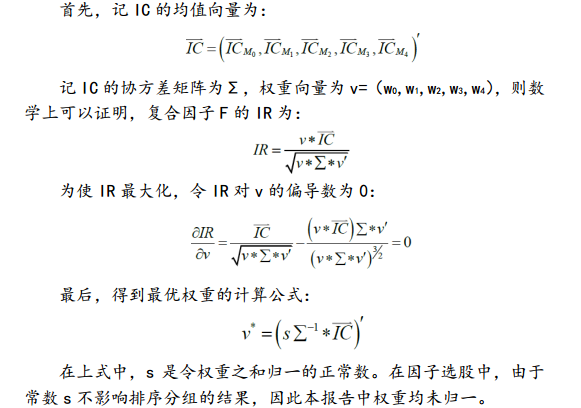


In [36]:
#最优权重计算
sigma = matrix(np.cov(ic_df.iloc[:5,:].values))
ic_mean = np.array((ic_df.iloc[:5,:].mean(axis=1).values)).reshape(5,1)
weight = ((sigma.I)*ic_mean)
weight

matrix([[1.2622574967887386],
        [1.0358522461394053],
        [-5.710516242248603],
        [-6.412955406765438],
        [4.4198671035088415]])

In [39]:
#进行归一化
weight = weight/sum(weight)
weight

matrix([[-0.2335137749437777],
        [-0.1916294962758202],
        [1.0564280331055225],
        [1.1863771293810288],
        [-0.8176618912669533]])

- 输入一个权重设置方案，返回一个合成因子，
- 统计合成因子与收益的IC，并计算IC_IR，
- 并进行不同参数输入，记录热力图示

In [40]:
#四个因子记录权重
w1,w2,w3,w4,w0 = np.array(weight).reshape(5,)
w1,w2,w3,w4,w0

(-0.2335137749437777,
 -0.1916294962758202,
 1.0564280331055225,
 1.1863771293810288,
 -0.8176618912669533)

In [42]:
weight_ht_w01 = pd.DataFrame()
#参数铭感度测（w0与w1）
for w_0 in linspace(w0-0.05*5,w0+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_1 in linspace(w1-0.05*5,w1+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w_1,w2,w3,w4,w_0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_1] = ic_temp_list
    weight_ht_w01[w_0] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)

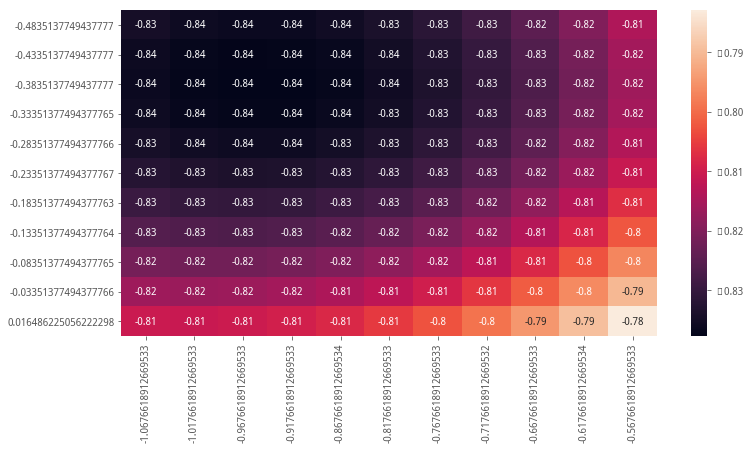

In [43]:
import seaborn as sns
#参数铭感度测试(w0与w1)
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w01,annot=True,annot_kws={'size':10,'weight':'bold'})

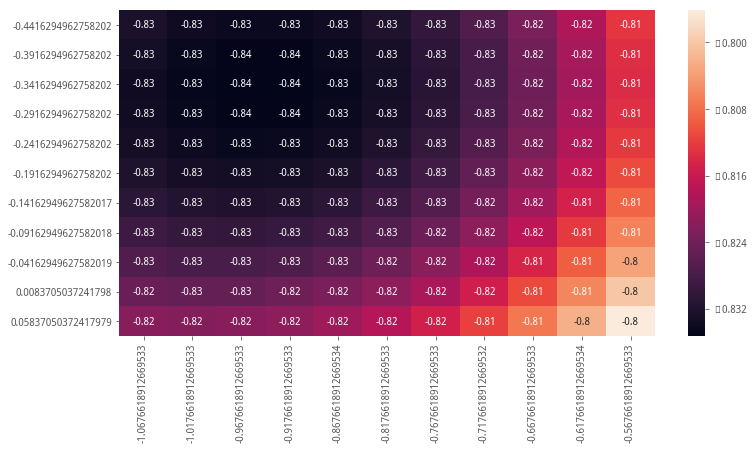

In [45]:
#参数铭感度测试(w0与w2)
weight_ht_w02 = pd.DataFrame()

#参数铭感度测（w0与w1）
for w_0 in linspace(w0-0.05*5,w0+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_2 in linspace(w2-0.05*5,w2+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w1,w_2,w3,w4,w_0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_2] = ic_temp_list
    weight_ht_w02[w_0] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)
    
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w02,annot=True,annot_kws={'size':10,'weight':'bold'})

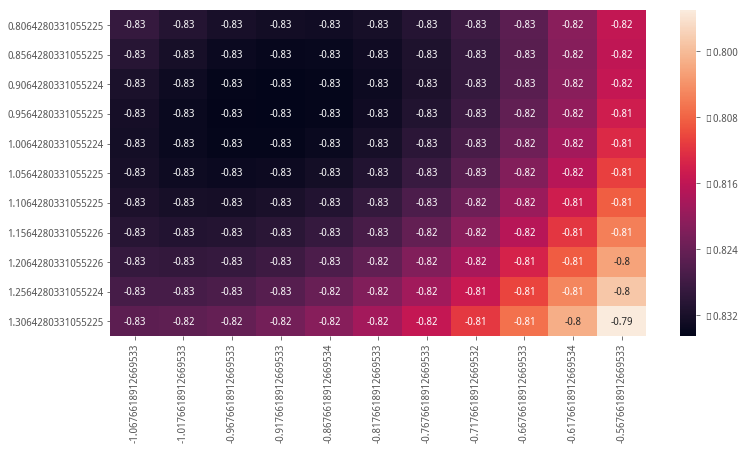

In [46]:
#参数铭感度测试(w0与w3)
weight_ht_w03 = pd.DataFrame()

for w_0 in linspace(w0-0.05*5,w0+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_3 in linspace(w3-0.05*5,w3+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w1,w2,w_3,w4,w_0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_3] = ic_temp_list
    weight_ht_w03[w_0] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)
    
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w03,annot=True,annot_kws={'size':10,'weight':'bold'})

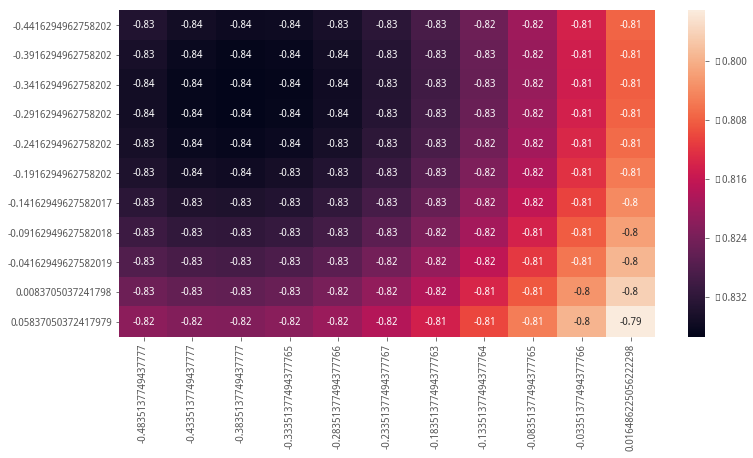

In [47]:
#参数铭感度测试(w1与w2)
weight_ht_w12 = pd.DataFrame()

for w_1 in linspace(w1-0.05*5,w1+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_2 in linspace(w2-0.05*5,w2+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w_1,w_2,w3,w4,w0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_2] = ic_temp_list
    weight_ht_w12[w_1] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)
    
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w12,annot=True,annot_kws={'size':10,'weight':'bold'})

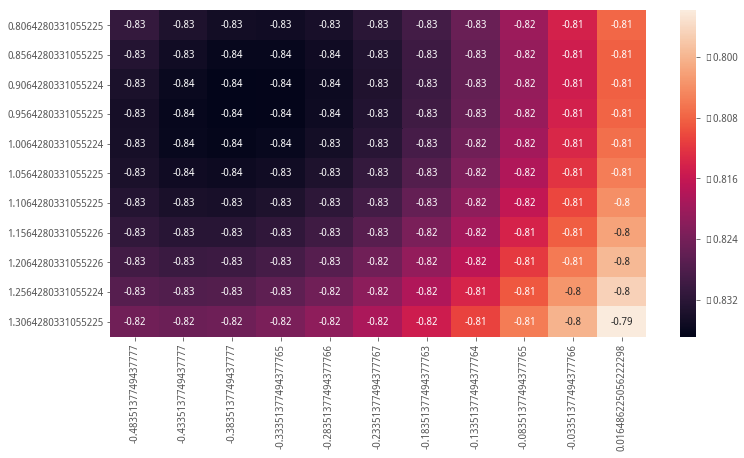

In [48]:
#参数铭感度测试(w1与w3)
weight_ht_w13 = pd.DataFrame()

for w_1 in linspace(w1-0.05*5,w1+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_3 in linspace(w3-0.05*5,w3+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w_1,w2,w_3,w4,w0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_3] = ic_temp_list
    weight_ht_w13[w_1] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)
    
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w13,annot=True,annot_kws={'size':10,'weight':'bold'})

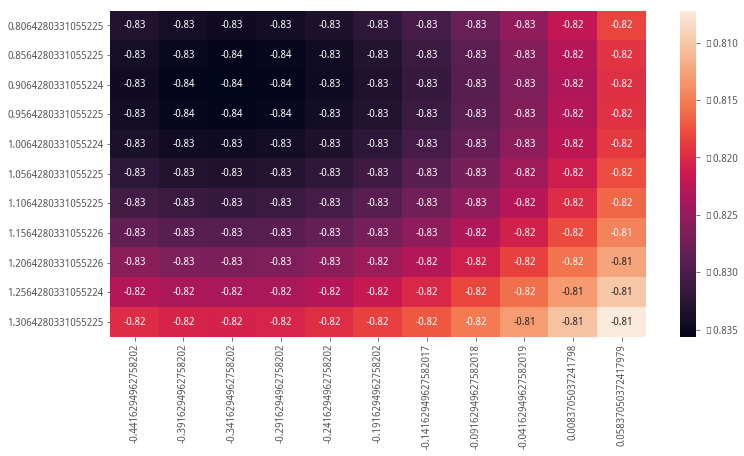

In [49]:
#参数铭感度测试(w2与w3)
weight_ht_w23 = pd.DataFrame()

for w_2 in linspace(w2-0.05*5,w2+0.05*5,11):
    weight1_df =  pd.DataFrame()
    for w_3 in linspace(w3-0.05*5,w3+0.05*5,11):
        ic_temp_list = [] 
        #参数铭感性测试
        for d in trade_list[1:-1]:
            factor_df = factor_y_dict[d]
            factor_df['factor'] = np.dot(factor_df[[1,2,3,4,0]],[w1,w_2,w_3,w4,w0])
            ic_temp_list.append(factor_df['pct'].corr(factor_df['factor']))
        weight1_df[w_3] = ic_temp_list
    weight_ht_w23[w_2] = weight1_df.mean(axis=0)/weight1_df.std(axis=0)
    
fig = plt.figure(figsize= (12,6))
ax = fig.add_subplot(111)
ax = sns.heatmap(weight_ht_w23,annot=True,annot_kws={'size':10,'weight':'bold'})

In [51]:
#计算因子值df
factor_df = pd.DataFrame()
mark = 1
#参数铭感性测试
for d in trade_list[1:-1]:
    d = str(d)[:10]
    factor_df_temp = factor_dict[d]
    factor_df_temp[d] = np.dot(factor_df_temp[[1,2,3,4,0]],[w1,w2,w3,w4,w0])
    if mark ==1:
        factor_df = pd.DataFrame(factor_df_temp[d],index=factor_df_temp.index)
        mark=0
    else:
        factor_df = pd.concat([factor_df,factor_df_temp[d]],axis=1)
factor_df = factor_df.T

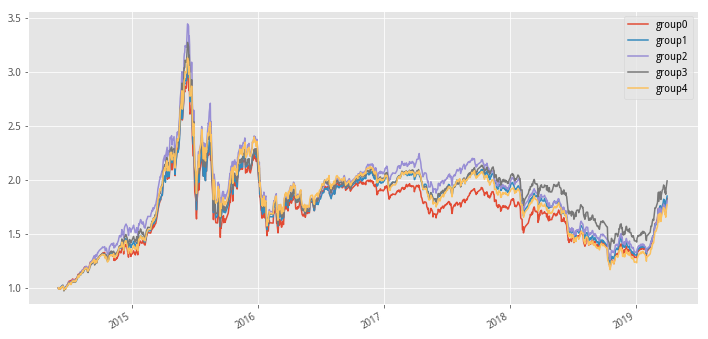

In [53]:
#进行回测数据分组统计
'''
分组回测部分
'''
#分组回测部分
#输入：index为日期，column是股票名，values是因子值得factor_df
#输出：股票池分组收益
group = 5 #分组组数
pool_dict = {}
for i in range(len(factor_df.index)):
    temp_se = factor_df.iloc[0,:].sort_values(ascending=False)#从大到小排序
    #pool = temp_se[temp_se>0].index #去掉小于0的值
    temp_se = temp_se.dropna() #去掉空值
    pool = temp_se.index #不做负值处理
    num = int(len(pool)/group)
    #print('第%s期每组%s只股票'%(i,num))
    pool_dict[factor_df.index[i]] = pool
trade_list = factor_df.index
group_pct = get_all_pct(pool_dict,trade_list,groups=group)
group_pct.columns = ['group'+str(i) for i in range(len(group_pct.columns))]
group_pct.cumprod().plot(figsize=(12,6))

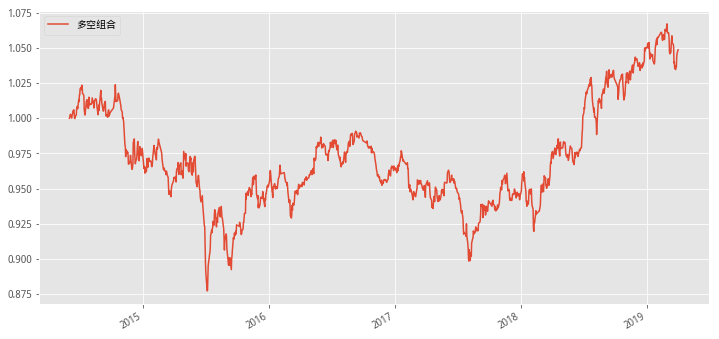

In [54]:
#多空组合收益曲线
se1 = group_pct['group0']-group_pct['group4']+1
df = pd.DataFrame(se1,columns=['多空组合'])
df.cumprod().plot(figsize=(12,6))

2014 年持仓交易换手率为： 6.32
2015 年持仓交易换手率为： 9.58
2016 年持仓交易换手率为： 9.9
2017 年持仓交易换手率为： 9.52
2018 年持仓交易换手率为： 9.6
策略每次调仓平均交易换手率为：0.882
=====策略运行时间：2014-06-03 至 2019-03-29=====


,总收益,年化收益,夏普率,最大回撤,每日收益
ret,104.52%,16.38%,0.34,57.32%,0.000898
alpha,46.26%,8.4%,0.3,8.58%,0.000341
index,51.68%,9.24%,0.16,65.85%,0.000556


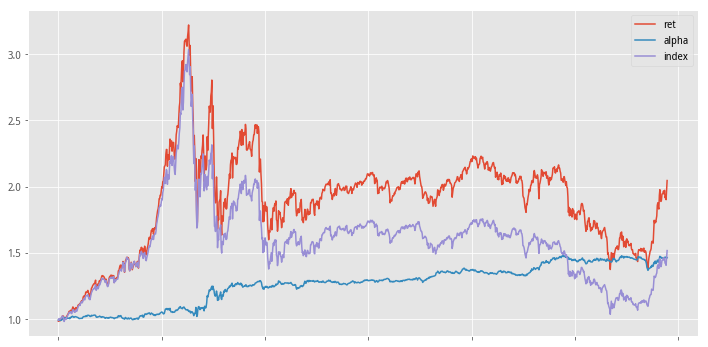

In [52]:
#选取头部股票构造组合进行回测
trade_list_ = get_tradeday_list(start=factor_df.index[0],end=factor_df.index[-1],count=None)
return_alpha_df = pd.DataFrame()
return_index_df = pd.DataFrame()
return_df = pd.DataFrame()
pool_temp_bf = []
tur = 0
tur_list = []
trade = 0
year = str(trade_list_[0])[:4]
for d1,d2 in zip(trade_list_[:-1],trade_list_[1:]):
    d1_ = ShiftTradingDay(d1,1) #往后推一天
    d2_ = ShiftTradingDay(d2,1)
    d1 = str(d1)[:10]
    d2 = str(d2)[:10]
    if d1 in factor_df.index:
        trade = 1
        #获取头部股票
        #print('{}进行调仓操作'.format(str(d1_)[:10]))
        df_temp = factor_df.loc[d1,:].sort_values(ascending=True) #mo默认从小到大排序
        df_temp = df_temp.dropna()
        pool_temp = df_temp.index[:50]
        trade_record_df[str(d1_)[:10]] = pool_temp
        tur_temp = len([stock for stock in pool_temp if stock not in pool_temp_bf])/len(pool_temp) #换手率
        tur_list.append(tur_temp)
        #print换手率
        if str(d1)[:4] == year:
            tur += tur_temp
        else:
            #print('{} 年持仓交易换手率为： {}'.format(year,round(tur,2)))
            tur = 0
            year = str(d1)[:4]
        pool_temp_bf = pool_temp
        
    #计算组合收益
    df1 = get_price(list(pool_temp),end_date=d1_,count=1,fields=['open'])['open'] #index为日期，columns为股票名称
    df1 = df1.dropna(axis=1) #去掉NAN值，删除列
    df2 = get_price(list(df1.columns),end_date=d2_,count=1,fields=['open'])['open']
    ret = (df2.values/df1.values).mean() #计算组合收益均值
    if trade == 1:
        ret = ret*(1-tur_temp*0.002)
        trade = 0
    #计算同期指数收益率
    df_index1 = get_price('000905.XSHG',end_date=d1_,count=1,fields=['open'])['open']
    df_index2 = get_price('000905.XSHG',end_date=d2_,count=1,fields=['open'])['open']
    index_ret = df_index2.values[-1]/df_index1.values[-1]

    return_alpha_df[d1] = [ret-index_ret]  #记录超额收益
    return_df[d1] = [ret]  #记录组合收益
    return_index_df[d1] = [index_ret]  #记录基准收益

return_df = return_df.T
return_alpha_df = return_alpha_df.T
return_index_df = return_index_df.T
return_all_df = pd.concat([return_df,return_alpha_df+1,return_index_df],axis=1)
return_all_df.columns = ['ret','alpha','index']

summary = pd.DataFrame(index=['总收益','年化收益','夏普率','最大回撤'])
summary['ret'] = get_risk_index(return_all_df['ret'].cumprod()-1)
summary['alpha']=get_risk_index(return_all_df['alpha'].cumprod()-1)
summary['index']=get_risk_index(return_all_df['index'].cumprod()-1)
summary = summary.T
summary['每日收益'] = (return_all_df-1).mean()
print('策略每次调仓平均交易换手率为：{}'.format(round(np.mean(tur_list),3)))
print('=====策略运行时间：{} 至 {}====='.format(str(return_all_df.index[0])[:10],str(return_all_df.index[-1])[:10]))
(return_all_df).cumprod().plot(figsize=(12,6))
summary